In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.autonotebook import tqdm
from PIL import Image
import yaml
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
DEVICE

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda:1'

In [2]:
from enum import Enum, unique

class Curvature(Enum):
    NO_CURVATURE = False
    CURVATURE = True


/tmp/ipykernel_2982/1539602785.py:11: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)


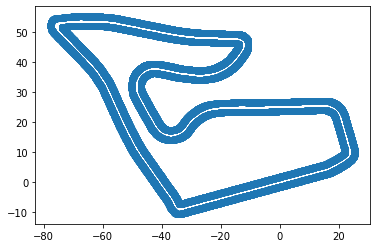

In [3]:
def _get_map_points(map_path, map_ext):
    with open(map_path + '.yaml', 'r') as yaml_stream:
        try:
            map_metadata = yaml.safe_load(yaml_stream)
            map_resolution = map_metadata['resolution']
            origin = map_metadata['origin']
            origin_x = origin[0]
            origin_y = origin[1]
        except yaml.YAMLError as ex:
            print(ex)
    map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)
    map_height = map_img.shape[0]
    map_width = map_img.shape[1]

    # convert map pixels to coordinates
    range_x = np.arange(map_width)
    range_y = np.arange(map_height)
    map_x, map_y = np.meshgrid(range_x, range_y)
    map_x = (map_x * map_resolution + origin_x).flatten()
    map_y = (map_y * map_resolution + origin_y).flatten()
    map_z = np.zeros(map_y.shape)
    map_coords = np.vstack((map_x, map_y, map_z))

    # mask and only leave the obstacle points
    map_mask = map_img == 0.0
    map_mask_flat = map_mask.flatten()
    map_points = map_coords[:, map_mask_flat].T
    return map_points[:,0], map_points[:,1]

map_x, map_y = _get_map_points("../data_generation/track_config/Spielberg_map", ".png")
plt.scatter(map_x, map_y)

In [4]:
from tensorboardX import SummaryWriter


In [5]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
full_frame = pd.read_pickle("../../data/final_data.pkl")

In [6]:
torch.tensor(np.array(train_frame.iloc[:9]['input_no_curve'].to_list())).shape

torch.Size([9, 10, 3])

In [7]:
class TraceRelativeDataset(Dataset):
    def __init__(self, dataframe, curve=False):
        self.dataframe = dataframe
        self.curve = curve

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.curve:
            key="input"
        else:
            key="input_no_curve"
        
        try:
            inputs = torch.tensor(np.array(self.dataframe.iloc[idx][key].to_list()), dtype=torch.float32)
            last_pose = torch.tensor(np.array(self.dataframe.iloc[idx]['last_pose'].to_list()), dtype=torch.float32)
            target = torch.tensor(np.array(self.dataframe.iloc[idx]['target'].to_list()), dtype=torch.float32)
        except AttributeError as v:
            inputs = torch.tensor(self.dataframe.iloc[idx][key], dtype=torch.float32)
            last_pose = torch.tensor(self.dataframe.iloc[idx]['last_pose'], dtype=torch.float32)
            target = torch.tensor(self.dataframe.iloc[idx]['target'], dtype=torch.float32)
        return inputs, last_pose, target

train_dataset = TraceRelativeDataset(train_frame, curve=False)
test_dataset = TraceRelativeDataset(test_frame, curve=False)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [34]:
def bicycle_model_eval(inputs, last_poses):
    # This version takes in an input of dim 5
    BATCHES = inputs.shape[0]
    states = []  # torch.zeros((81, 4))
    L = 0.3302
    TS = 0.1
    X, Y, THETA, V = 0, 1, 2, 3
    state = torch.zeros((BATCHES, 4,))
    state[:,X] = last_poses[:,0]
    state[:,Y] = last_poses[:,1]
    state[:,THETA] = last_poses[:,2]
    state[:,V] = inputs[:,0]
    states.append(state)
    for i in range(1,81):
        # Advance bicycle model
        state = torch.zeros((BATCHES, 4,))
        state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
        state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
        state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(inputs[:,1])) / L)
        state[:,V] = states[i-1][:,V] + TS*inputs[:,2]
        states.append(state)
    trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
    trace = trace[:,1:,:3]
    return trace

def custom_loss_func(prediction, target):
    loss = F.smooth_l1_loss(prediction[:,:,:2], target[:,:,:2])
    loss += 4*F.smooth_l1_loss(prediction[:,:,2], target[:,:,2])
    #loss += 10*output[0]**2 if output[0]<0 else 0
    #loss += 2*torch.linalg.norm(output)**2
    return loss

def average_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[:,:,:2]-target[:,:,:2], dim=2)
    ade = torch.mean(loss, dim=0)
    return torch.mean(ade)

def final_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[:,-1,:2]-target[:,-1,:2], dim=1)
    return torch.mean(loss)

class LSTMPredictorBicycle(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, control_outputs=1):
        super(LSTMPredictorBicycle, self).__init__()
        self.hidden_dim = hidden_dim
        self.control_outputs = control_outputs

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=4, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.Linear(hidden_dim//2, 1+control_outputs*2)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        scaled_output = list()
        scaled_output.append(F.softplus(output[:,:,0]))
        for step in range(self.control_outputs):
            scaled_output.append(torch.tanh(output[:,:,(step*2)+1])*np.pi)
            scaled_output.append(output[:,:,(step*2)+2])
        output = torch.dstack(scaled_output)
        return output
    
    def predict(self, inputs, last_poses, horizon=60):
        # Compute LSTM output
        controls = self.forward(inputs)[:, -1]  # Take last prediction
        last_poses = last_poses.to(DEVICE)
        BATCHES = controls.shape[0]
        states = []  # torch.zeros((81, 4))
        L = 0.3302
        TS = 0.1
        X, Y, THETA, V = 0, 1, 2, 3
        CDIMS = 2
        state = torch.zeros((BATCHES, 4,), device=DEVICE)
        state[:,X] = last_poses[:,0]
        state[:,Y] = last_poses[:,1]
        state[:,THETA] = last_poses[:,2]
        state[:,V] = controls[:,0]
        states.append(state)
        step_length = horizon//self.control_outputs
        for i in range(1,horizon+1):
            # Advance bicycle model
            step = min((i-1)//step_length, self.control_outputs-1)
            state = torch.zeros((BATCHES, 4,), device=DEVICE)
            state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
            state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
            state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(controls[:,(step*CDIMS)+1])) / L)
            state[:,V] = states[i-1][:,V] + TS*controls[:,(step*CDIMS)+2]
            states.append(state)
        trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
        trace = trace[:,1:,:3]
        return trace

In [32]:
60//8

7

In [9]:
def create_debug_plot(net, train_dataset:TraceRelativeDataset=train_dataset, test_dataset:TraceRelativeDataset=test_dataset, curvature:Curvature=Curvature.NO_CURVATURE):
    selection = [1912, 2465, 533, 905, 277, 1665, 2395, 61, 1054]
    inputs, last_poses, targets = train_dataset[:len(selection)]
    inputs = torch.zeros_like(inputs, dtype=torch.float32, device=DEVICE)
    last_poses = torch.zeros_like(last_poses, dtype=torch.float32, device=DEVICE)
    for i, DATA_IDX in enumerate(selection):
        data_in_train = True if DATA_IDX in train_frame.index else False
        if data_in_train:
            dframe = train_frame
        else:
            dframe = test_frame
        if curvature is Curvature.NO_CURVATURE:
            inputs[i] = torch.tensor(dframe.loc[DATA_IDX]['input_no_curve'], dtype=torch.float32, device=DEVICE)
        else:
            inputs[i] = torch.tensor(dframe.loc[DATA_IDX]['input'], dtype=torch.float32, device=DEVICE)
        last_poses[i] = torch.tensor(dframe.loc[DATA_IDX]['last_pose'], dtype=torch.float32, device=DEVICE)
        targets[i] = torch.tensor(dframe.loc[DATA_IDX]['target'], dtype=torch.float32, device=DEVICE)
    outputs = net.predict(inputs, last_poses).detach().cpu().numpy()

    fig, axs = plt.subplots(3,3,figsize=(10,10), dpi=300)
    for idx, DATA_IDX in enumerate(selection):
        data_in_train = True if DATA_IDX in train_frame.index else False
        if data_in_train:
            dframe = train_frame
        else:
            dframe = test_frame
        linput, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['input'][:,0], dframe.loc[DATA_IDX]['input'][:,1], marker='.', label="Input")
        ltarget, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['target'][:,0], dframe.loc[DATA_IDX]['target'][:,1], marker='.', label="Target")
        lpred, = axs[idx//3, idx%3].plot(outputs[idx,:,0], outputs[idx,:,1], marker='x', label="Prediction")
        xlim, ylim = np.average(axs[idx//3, idx%3].get_xlim()), np.average(axs[idx//3, idx%3].get_ylim())
        axs[idx//3, idx%3].scatter(map_x, map_y, marker=".", color='black')
        axs[idx//3, idx%3].set(xlim=(xlim-3.5,xlim+3.5),
                               ylim=(ylim-3.5,ylim+3.5),
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
        axs[idx//3, idx%3].set_title("{}:{}".format("Train" if data_in_train else "Test",DATA_IDX))
    fig.suptitle("Manually Selected Traces")
    fig.legend(handles=[linput, ltarget, lpred])
    return fig, axs

In [10]:
net = LSTMPredictorBicycle()
net.to(DEVICE)
#net.load_state_dict(torch.load("best_simple_bicycle.pt"))
for input, last_pose, target in train_dataloader:
    break;
display(input.shape)
display(last_pose.shape)
display(target.shape)
input = input.to(DEVICE)
last_pose = last_pose.to(DEVICE)
other_outp = net.predict(input, last_pose)
other_outp.shape

torch.Size([32, 10, 3])

torch.Size([32, 3])

torch.Size([32, 60, 3])

torch.Size([32, 60, 3])

0.2942073345184326

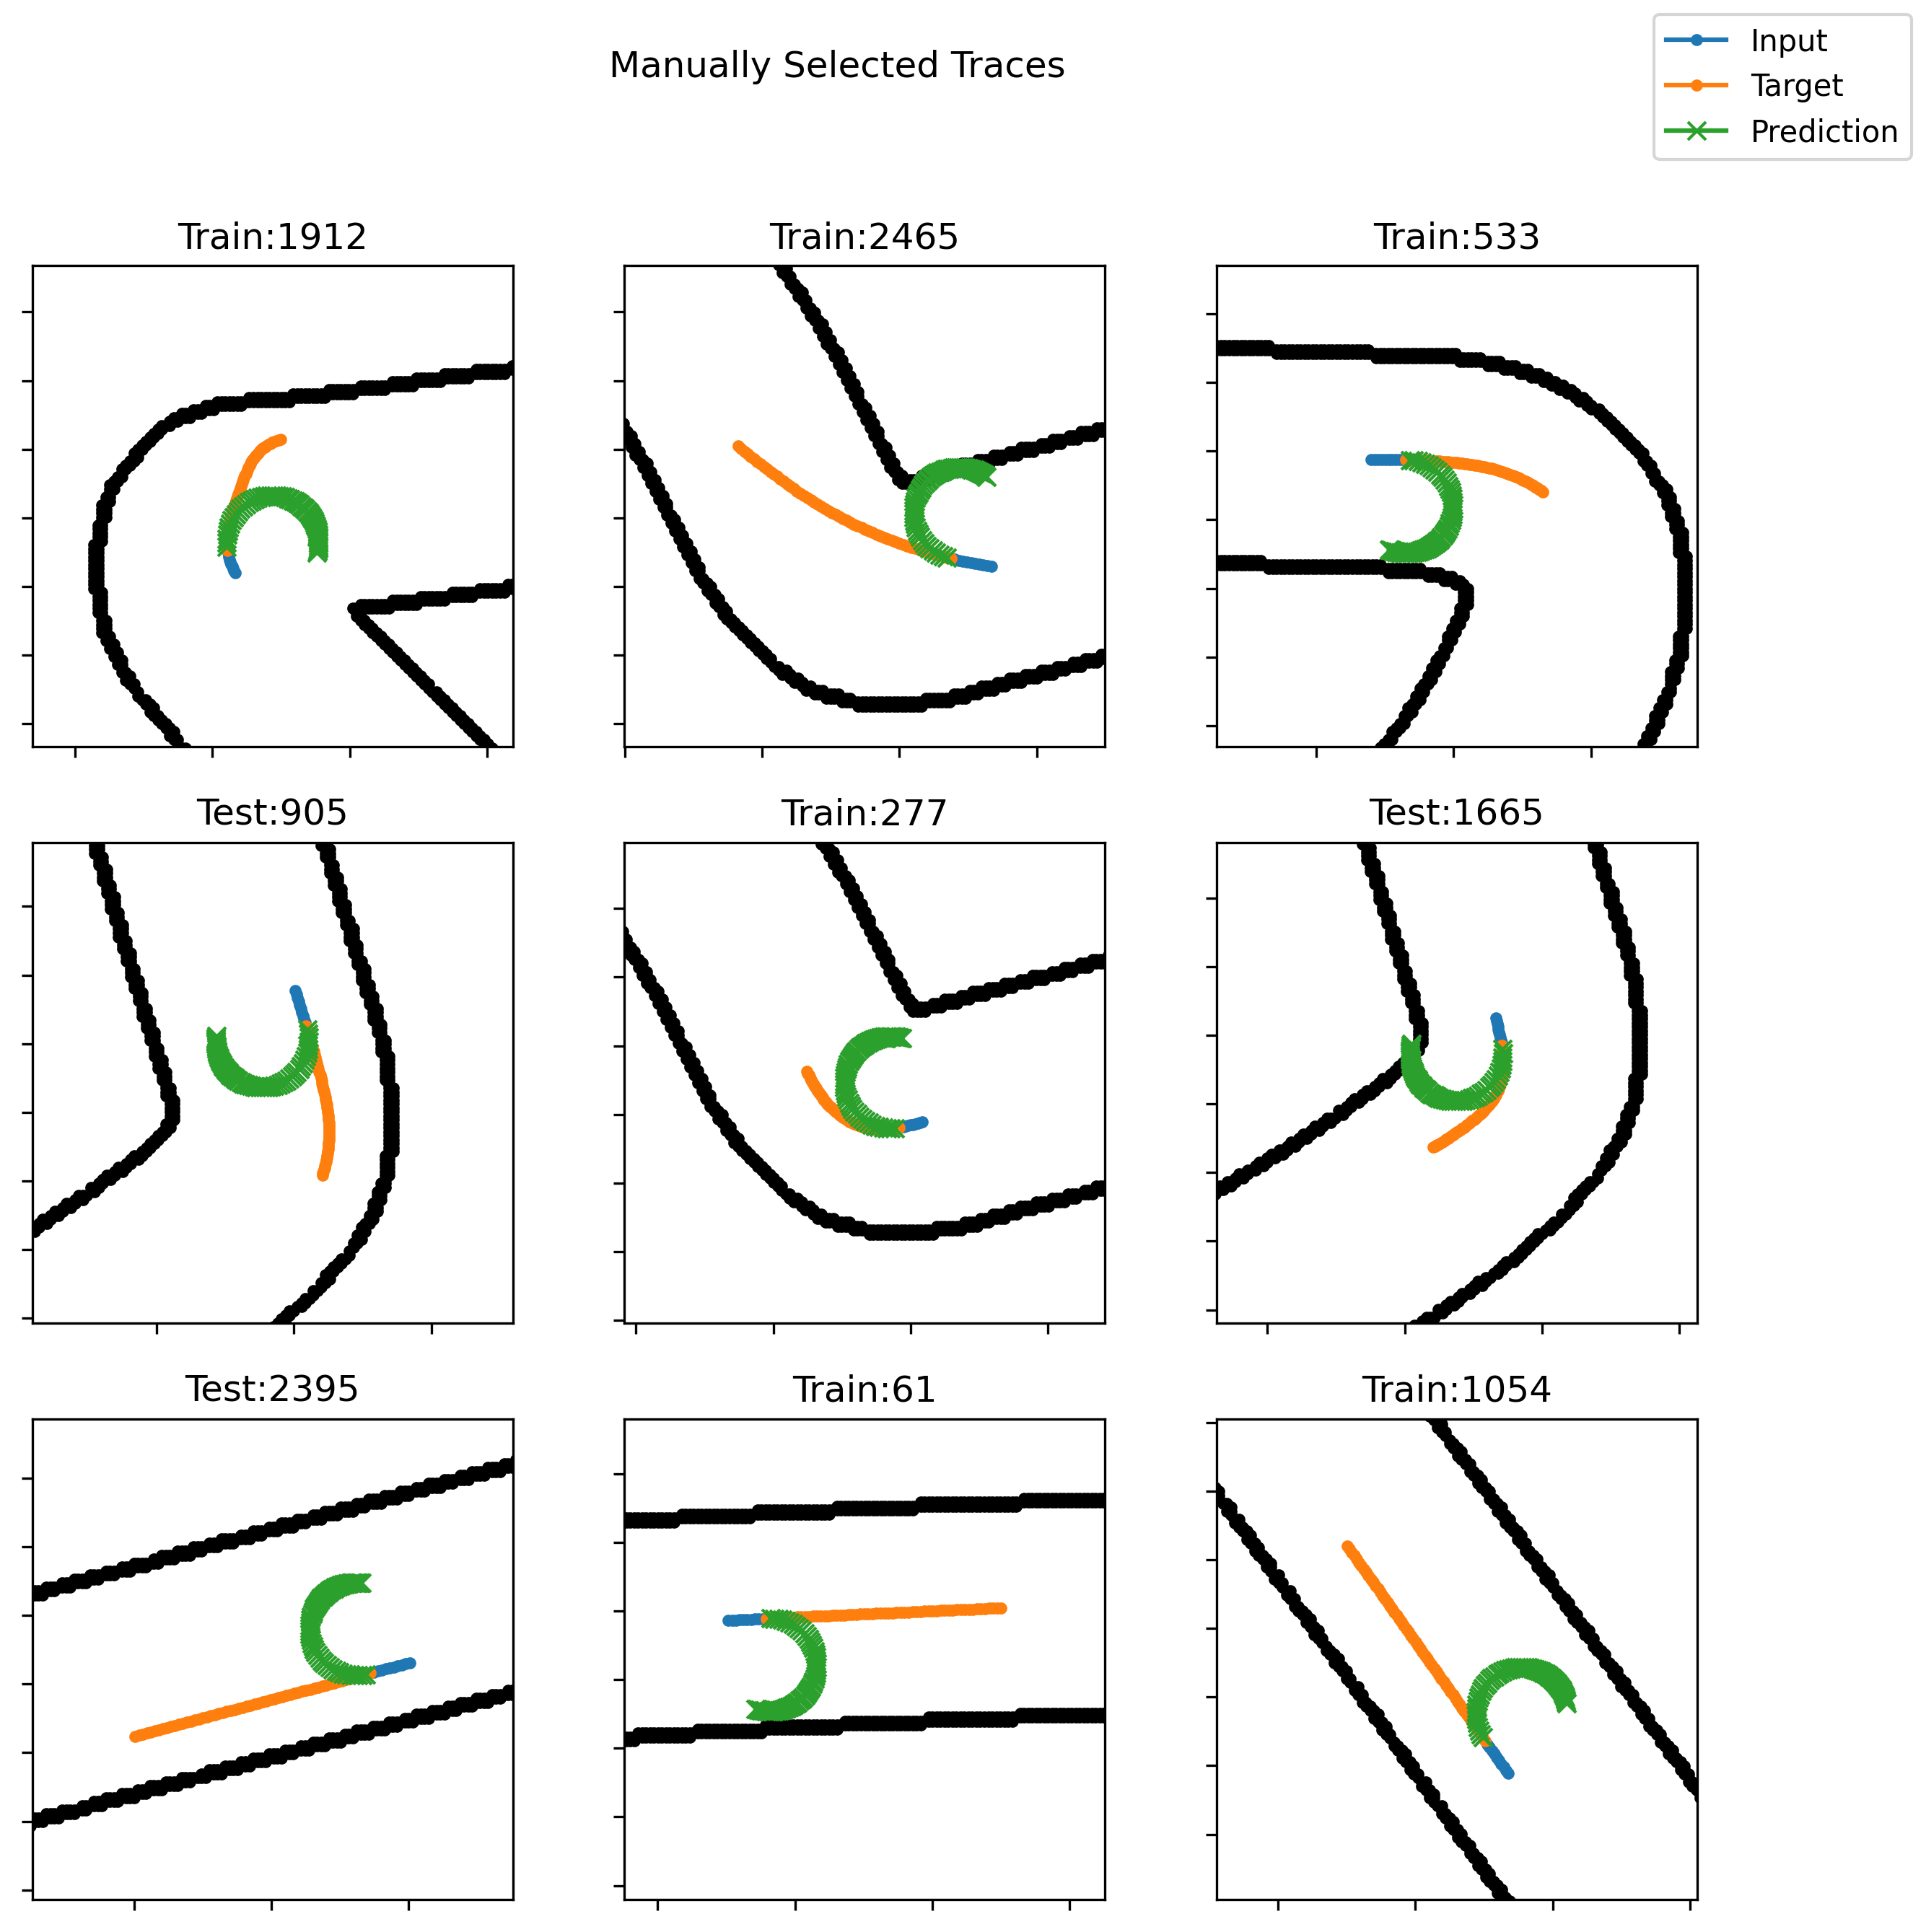

In [11]:
import time
start = time.time()
create_debug_plot(net)
end = time.time()
end-start

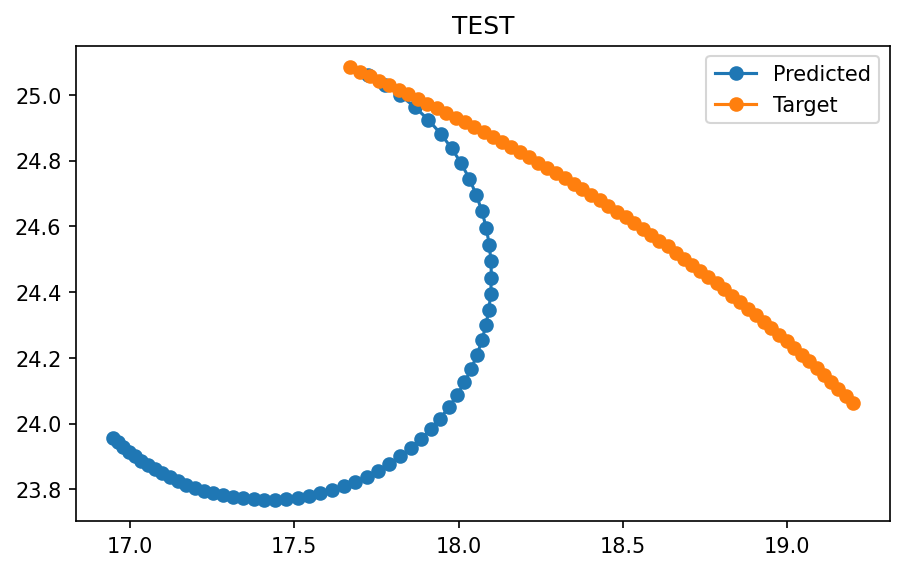

In [12]:
dfig, ax = plt.subplots(figsize=(7,7), dpi=150);
ax.set_aspect(1.0, adjustable='box');
ax.set_title("TEST");
ax.plot(other_outp[0,:,0].cpu().detach().numpy(), other_outp[0,:,1].cpu().detach().numpy(), marker='o', label='Predicted');
ax.plot(target[0,:,0].detach().numpy(), target[0,:,1].detach().numpy(), marker='o', label='Target');
ax.legend();

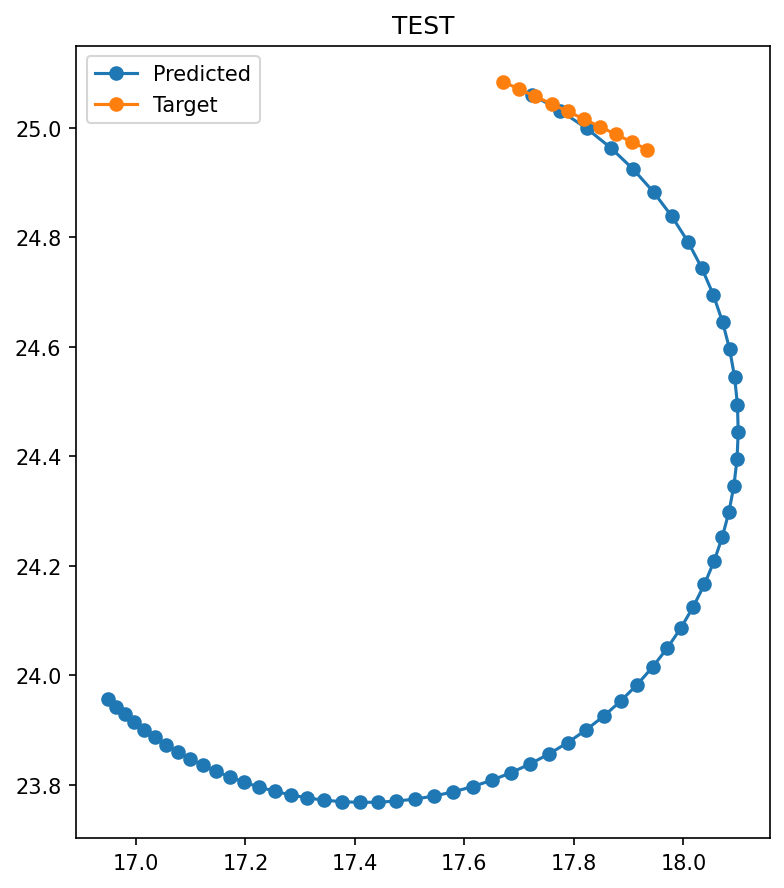

In [13]:
fig, ax = plt.subplots(figsize=(7,7), dpi=150);
ax.set_aspect(1.0, adjustable='box');
ax.set_title("TEST");
ax.plot(other_outp[0,:,0].cpu().detach().numpy(), other_outp[0,:,1].cpu().detach().numpy(), marker='o', label='Predicted')
ax.plot(target[0,:10,0].detach().numpy(), target[0,:10,1].detach().numpy(), marker='o', label='Target')
ax.legend()

In [14]:
loss = nn.MSELoss()
loss(other_outp,torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32, device=DEVICE))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([60, 3])) that is different to the input size (torch.Size([32, 60, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(342.9942, device='cuda:1', grad_fn=<MseLossBackward0>)

In [27]:
def train(control_outputs:int, curvature:Curvature, hidden_dim:int=32, epochs=100):
    directory = f'runs/hyp-search/bicycle-{control_outputs}-{curvature.name}-{hidden_dim}/'
    writer = SummaryWriter(directory)

    train_dataset = TraceRelativeDataset(train_frame, curve=True if curvature is Curvature.CURVATURE else False)
    test_dataset = TraceRelativeDataset(test_frame, curve=True if curvature is Curvature.CURVATURE else False)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    # Training Loop
    torch.autograd.set_detect_anomaly(True)
    net = LSTMPredictorBicycle(input_dim=9 if curvature is Curvature.CURVATURE else 3,
                               hidden_dim=hidden_dim,
                               control_outputs=control_outputs)
    net.to(DEVICE)
    pytorch_total_params = sum(p.numel() for p in net.parameters())
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    train_losses = list()
    test_losses = list()
    train_ades, test_ades = list(), list()
    train_fdes, test_fdes = list(), list()

    for epoch in range(epochs):
        cum_train_loss = 0.0
        net.train()
        i=0
        fde, ade = list(), list()

        for input_data, last_pose, target_data in tqdm(train_dataloader):
            net.zero_grad()
            input_data = input_data.to(DEVICE)
            last_pose = last_pose.to(DEVICE)
            outp = net.predict(input_data, last_pose)
            target_data = target_data.to(DEVICE)
            loss = custom_loss_func(outp, target_data)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                fde.append(final_displacement_error(outp, target_data).cpu().numpy())
                ade.append(average_displacement_error(outp, target_data).cpu().numpy())
            cum_train_loss += loss.item()

        train_fig, train_ax = create_debug_plot(net, train_dataset, test_dataset, curvature)
        cum_train_loss /= len(train_dataset)
        train_losses.append(cum_train_loss)
        ade, fde = np.mean(ade), np.mean(fde)
        writer.add_scalar("ADE/train", ade, epoch)
        writer.add_scalar("FDE/train", fde, epoch)
        train_ades.append(ade)
        train_fdes.append(fde)
        cum_test_loss = 0.0
        fde, ade = list(), list()
        net.eval()
        with torch.no_grad():
            for input_data, last_pose, target_data in tqdm(test_dataloader):
                input_data = input_data.to(DEVICE)
                last_pose = last_pose.to(DEVICE)
                outp = net.predict(input_data, last_pose)
                target_data = target_data.to(DEVICE)
                loss = custom_loss_func(outp, target_data)
                cum_test_loss += loss.item()
                fde.append(final_displacement_error(outp, target_data).cpu().numpy())
                ade.append(average_displacement_error(outp, target_data).cpu().numpy())
            test_fig, test_ax = create_debug_plot(net, train_dataset, test_dataset, curvature)
        cum_test_loss /= len(test_dataset)
        test_losses.append(cum_test_loss)
        ade, fde = np.mean(ade), np.mean(fde)
        writer.add_scalar("ADE/test", ade, epoch)
        writer.add_scalar("FDE/test", fde, epoch)
        test_ades.append(ade)
        test_fdes.append(fde)
        if cum_test_loss <= min(test_losses):
            torch.save(net.state_dict(), f"{directory}/best_model.pt")
        writer.add_scalar("loss/train", cum_train_loss, epoch)
        writer.add_scalar("loss/test", cum_test_loss, epoch)
        writer.add_figure("train/example_fig", train_fig, epoch)
        writer.add_figure("test/example_fig", test_fig, epoch)
        tqdm.write(f"Epoch {epoch} | Train Loss: {cum_train_loss} | Test Loss: {cum_test_loss}")
    return {
        'control_outputs': control_ouptut,
        'curvature': curvature,
        'hidden_dims': hidden_dims,
        'training_loss': cum_train_loss,
        'test_loss': cum_test_loss,
        'ade': ade,
        'fde': fde,
        'params': pytorch_total_params
    }

def train_catch(*args, **kwargs):
    import traceback
    try:
        train(*args, **kwargs)
    except Exception as e:
        print("Exception Occurred:")
        print(e)
        traceback.print_exc()
        print("--------------------")

In [16]:
hyperparameters = {
    'control_outputs': [1,2,4,8,10,15,20,30],
    'curvature': [Curvature.NO_CURVATURE, Curvature.CURVATURE],
    'hidden_dims': [32, 16, 64],
}
hyp_packages = list()
for control_ouptut in hyperparameters['control_outputs']:
    for curvature in hyperparameters['curvature']:
        for hidden_dims in hyperparameters['hidden_dims']:
            hyp_packages.append({
                'control_outputs': control_ouptut,
                'curvature': curvature,
                'hidden_dims': hidden_dims,})

In [35]:
#train(8, Curvature.NO_CURVATURE, 64, 2)

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 34.93it/s]


Epoch 0 | Train Loss: 0.03503224816170079 | Test Loss: 0.028542148182168603


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 34.32it/s]


Epoch 1 | Train Loss: 0.026991892813160355 | Test Loss: 0.028207735928137682


{'control_outputs': 30,
 'curvature': <Curvature.NO_CURVATURE: False>,
 'hidden_dims': 64,
 'training_loss': 0.026991892813160355,
 'test_loss': 0.028207735928137682,
 'ade': 0.29246983,
 'fde': 0.5844834,
 'params': 122257}

In [36]:
pytorch_total_params = sum(p.numel() for p in net.parameters())
pytorch_total_params

31203

In [ ]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=4)(delayed(train_catch)(pkg['control_outputs'], pkg['curvature'], pkg['hidden_dims'],200) for pkg in hyp_packages)

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.04218259422702441 | Test Loss: 0.028661650204513636



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.027430709043629372 | Test Loss: 0.02828391884557075


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.07286921075563861 | Test Loss: 0.028794753779139783
Epoch 0 | Train Loss: 0.09664336819166106 | Test Loss: 0.033180831362389855


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.02720381170802537 | Test Loss: 0.02844149640036954


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.02696778862490331 | Test Loss: 0.028343694168142974


  1%|▏         | 1/72 [00:00<00:46,  1.53it/s]

Epoch 1 | Train Loss: 0.026679798316608605 | Test Loss: 0.0277699542671649
Epoch 1 | Train Loss: 0.02845196155013984 | Test Loss: 0.029075532892925873


 44%|████▍     | 8/18 [00:00<00:00, 32.01it/s]

Epoch 2 | Train Loss: 0.026977901388247773 | Test Loss: 0.028080711787980463


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.02634957192755336 | Test Loss: 0.027295711346798472
Epoch 2 | Train Loss: 0.026854331953876646 | Test Loss: 0.02822428483179667


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.02760642495080764 | Test Loss: 0.028836001771398716


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.026662429432173482 | Test Loss: 0.0275331681025111


  8%|▊         | 6/72 [00:04<00:42,  1.55it/s]]

Epoch 3 | Train Loss: 0.025982459892173314 | Test Loss: 0.027019217946670122



 10%|▉         | 7/72 [00:05<00:41,  1.56it/s]

Epoch 3 | Train Loss: 0.026800091492479826 | Test Loss: 0.028124050159628194



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.027532313692243487 | Test Loss: 0.029332880448136065


 94%|█████████▍| 68/72 [01:29<00:04,  1.21s/it]

Epoch 4 | Train Loss: 0.026316900044148845 | Test Loss: 0.02771959841872255



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.02577602717666187 | Test Loss: 0.02684573413959394


 12%|█▎        | 9/72 [00:08<00:44,  1.41it/s]

Epoch 4 | Train Loss: 0.026706005369744334 | Test Loss: 0.027973533763239782



  3%|▎         | 2/72 [00:01<00:48,  1.44it/s]

Epoch 4 | Train Loss: 0.02742285232062085 | Test Loss: 0.028649555389872856


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.025826135965842562 | Test Loss: 0.0271143965009186


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.02545756565894022 | Test Loss: 0.026610620856647275


  3%|▎         | 2/72 [00:01<00:59,  1.17it/s]]

Epoch 5 | Train Loss: 0.026610630312748414 | Test Loss: 0.027870945386692055
Epoch 5 | Train Loss: 0.027243999960135625 | Test Loss: 0.028488198592741456


 93%|█████████▎| 67/72 [01:28<00:06,  1.21s/it]

Epoch 6 | Train Loss: 0.02587084967212559 | Test Loss: 0.027223517432705395


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.02541922929848048 | Test Loss: 0.02703985404352554


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.027106888779964165 | Test Loss: 0.02828684683320009
Epoch 6 | Train Loss: 0.0264209544918881 | Test Loss: 0.027486978803709563


 89%|████████▉ | 64/72 [01:24<00:08,  1.10s/it]

Epoch 7 | Train Loss: 0.02568280324178038 | Test Loss: 0.027030965054614678


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.025463091661032132 | Test Loss: 0.02630725995792697



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.026061267647843687 | Test Loss: 0.027300022206165724
Epoch 7 | Train Loss: 0.026977987291629577 | Test Loss: 0.028297881569920316


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.02567563792099961 | Test Loss: 0.026610722144444782


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.025111412704735346 | Test Loss: 0.02622138268391912


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.026951561451320747 | Test Loss: 0.028061790210712288



 19%|█▉        | 14/72 [00:15<00:46,  1.25it/s]

Epoch 8 | Train Loss: 0.025658046210153947 | Test Loss: 0.02685392839420173


 86%|████████▌ | 62/72 [01:21<00:10,  1.09s/it]

Epoch 9 | Train Loss: 0.025604521862185075 | Test Loss: 0.026713964387050107


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.025108198526045948 | Test Loss: 0.026434572077252798


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.02682907857020247 | Test Loss: 0.027802384975883696



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.025316182328153445 | Test Loss: 0.02693635816427155


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.02551100987675628 | Test Loss: 0.026835807624997363


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.025041825941510557 | Test Loss: 0.02601183785332574


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.026480197901639288 | Test Loss: 0.027564361911370523


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.025678053174611283 | Test Loss: 0.02679848636034876


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.025469124721740247 | Test Loss: 0.027341048065055575


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.02515605489903823 | Test Loss: 0.02649440199861096


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.026347719408008556 | Test Loss: 0.0272798672473679


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.025516079283998284 | Test Loss: 0.02631859049304492


 93%|█████████▎| 67/72 [01:26<00:05,  1.08s/it]

Epoch 12 | Train Loss: 0.025619445082211267 | Test Loss: 0.026825360054822847



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.024940392653418172 | Test Loss: 0.024015712247799255


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.02622144850542191 | Test Loss: 0.027074848987265594



 24%|██▎       | 17/72 [00:20<00:58,  1.06s/it]

Epoch 12 | Train Loss: 0.02539127735302927 | Test Loss: 0.02633507155244135


 82%|████████▏ | 59/72 [01:18<00:14,  1.12s/it]

Epoch 13 | Train Loss: 0.02544644475306872 | Test Loss: 0.026990981701399304


 93%|█████████▎| 67/72 [01:28<00:05,  1.11s/it]

Epoch 13 | Train Loss: 0.02563738648162315 | Test Loss: 0.026333828831815884


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.025955259822613253 | Test Loss: 0.02707104069284267
Epoch 13 | Train Loss: 0.025313302667424743 | Test Loss: 0.02694753803209298


 81%|████████  | 58/72 [01:16<00:15,  1.13s/it]

Epoch 14 | Train Loss: 0.025337357205103314 | Test Loss: 0.0262672323668893


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.025156706909800385 | Test Loss: 0.02664239714956946


 25%|██▌       | 18/72 [00:20<00:47,  1.15it/s]

Epoch 14 | Train Loss: 0.025891082709271634 | Test Loss: 0.027097831687165633



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.02552784448708015 | Test Loss: 0.026107710301099967


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.025289891808771964 | Test Loss: 0.02609328225824154


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.025680054221901037 | Test Loss: 0.02654411525064562


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.025679495764959388 | Test Loss: 0.027405794852206275


 17%|█▋        | 12/72 [00:14<00:59,  1.00it/s]

Epoch 15 | Train Loss: 0.024906480467217215 | Test Loss: 0.025964267196185473


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.025263467603739348 | Test Loss: 0.02653945013622029


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.024417171143092456 | Test Loss: 0.026014402845046587


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.026119020949566914 | Test Loss: 0.02794106771600329


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.025480096500292485 | Test Loss: 0.026670738336785387


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.025066408101343054 | Test Loss: 0.026999102426796324


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.024529004179031873 | Test Loss: 0.02371546392613608


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.025571866092845785 | Test Loss: 0.026419246420522943


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.025301579152962935 | Test Loss: 0.025962854761423335


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.025778766472271272 | Test Loss: 0.02629832075520729


 85%|████████▍ | 61/72 [01:19<00:11,  1.07s/it]

Epoch 18 | Train Loss: 0.024401010999651862 | Test Loss: 0.024341388864235744


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.025808214555477497 | Test Loss: 0.027096189157519903


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.025174960166338887 | Test Loss: 0.027099778617007866


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.02522801454919354 | Test Loss: 0.026670744228694174


 10%|▉         | 7/72 [00:08<01:15,  1.16s/it]

Epoch 19 | Train Loss: 0.023978769589866066 | Test Loss: 0.02545029976560424


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.025757920228391497 | Test Loss: 0.026904574556586642


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.025626969379700597 | Test Loss: 0.026734107264524534


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.025123755674935442 | Test Loss: 0.02648241185104578


 10%|▉         | 7/72 [00:08<01:06,  1.02s/it]]

Epoch 20 | Train Loss: 0.02487586097359709 | Test Loss: 0.025681845792051818



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.025786744467881737 | Test Loss: 0.02750792667373187


  4%|▍         | 3/72 [00:03<01:15,  1.10s/it]

Epoch 20 | Train Loss: 0.025301837986197603 | Test Loss: 0.02640326027499719


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.02503561836098532 | Test Loss: 0.025971657208477456


 10%|▉         | 7/72 [00:08<01:12,  1.12s/it]

Epoch 21 | Train Loss: 0.02449630005859635 | Test Loss: 0.02500157419449857


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.02581609660463422 | Test Loss: 0.026311381901096966


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.02510743440378888 | Test Loss: 0.026257609793295462


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.025246742378101466 | Test Loss: 0.02572473042851521


 86%|████████▌ | 62/72 [01:19<00:10,  1.06s/it]

Epoch 22 | Train Loss: 0.024293140352879213 | Test Loss: 0.024885627803289227


 18%|█▊        | 13/72 [00:17<01:03,  1.08s/it]

Epoch 22 | Train Loss: 0.025604497388872657 | Test Loss: 0.02720233497287457



 24%|██▎       | 17/72 [00:21<00:57,  1.05s/it]

Epoch 22 | Train Loss: 0.024867033400612484 | Test Loss: 0.025705757243688114


 71%|███████   | 51/72 [01:06<00:22,  1.06s/it]

Epoch 23 | Train Loss: 0.025002067054999744 | Test Loss: 0.02584948680467076


 86%|████████▌ | 62/72 [01:19<00:10,  1.06s/it]

Epoch 23 | Train Loss: 0.02378157713813796 | Test Loss: 0.025666782050393522


100%|██████████| 72/72 [01:33<00:00,  1.29s/it]

Epoch 23 | Train Loss: 0.025752249498286008 | Test Loss: 0.027261778117261


 33%|███▎      | 24/72 [00:29<00:48,  1.00s/it]

Epoch 23 | Train Loss: 0.02505342639597549 | Test Loss: 0.025773721190893814


 71%|███████   | 51/72 [01:06<00:21,  1.03s/it]

Epoch 24 | Train Loss: 0.025009117371602538 | Test Loss: 0.025757860916201025


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.024626052338827392 | Test Loss: 0.02632284649169176


 29%|██▉       | 21/72 [00:26<00:57,  1.12s/it]

Epoch 24 | Train Loss: 0.025876926567298654 | Test Loss: 0.026813227353462327


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.024662342306054953 | Test Loss: 0.02622165762457169


 69%|██████▉   | 50/72 [01:06<00:26,  1.22s/it]

Epoch 25 | Train Loss: 0.024838697275294107 | Test Loss: 0.026186694714447692


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.024290810347244233 | Test Loss: 0.02641598438559514


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.025769148398996643 | Test Loss: 0.02691457301585211


  7%|▋         | 5/72 [00:05<01:11,  1.07s/it]]


Epoch 25 | Train Loss: 0.025029089544567205 | Test Loss: 0.025880297684731584


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.024614223388293117 | Test Loss: 0.02552300796378404


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.024769401072575463 | Test Loss: 0.025860892518216536


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.025623698434836962 | Test Loss: 0.02684689423121098


 25%|██▌       | 18/72 [00:23<01:02,  1.17s/it]

Epoch 26 | Train Loss: 0.024725635306218675 | Test Loss: 0.024945673222343128


 94%|█████████▍| 68/72 [01:28<00:04,  1.04s/it]

Epoch 27 | Train Loss: 0.024431870641796926 | Test Loss: 0.026203842600807548


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.02559339911470612 | Test Loss: 0.02609065319928858


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.025570268034740804 | Test Loss: 0.026701844232674275


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.02529132480188544 | Test Loss: 0.02656274767489069


 68%|██████▊   | 49/72 [01:04<00:26,  1.13s/it]

Epoch 28 | Train Loss: 0.025626356866401658 | Test Loss: 0.02623711868848962


 88%|████████▊ | 63/72 [01:21<00:10,  1.17s/it]

Epoch 28 | Train Loss: 0.024556252481553423 | Test Loss: 0.024487559994061787


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.0253844049319845 | Test Loss: 0.027075367604589298


 28%|██▊       | 20/72 [00:25<00:59,  1.14s/it]

Epoch 28 | Train Loss: 0.024909646595811245 | Test Loss: 0.025370247920768127


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.02481056722957191 | Test Loss: 0.02567988944550355


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.025203037298212456 | Test Loss: 0.026447351814972028


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.02532766548209507 | Test Loss: 0.026282641034211136


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.024207103817839398 | Test Loss: 0.02738982850375275


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.024812841524153972 | Test Loss: 0.02598756388761103


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.024783764692342197 | Test Loss: 0.023798327731330775


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.02515466949966397 | Test Loss: 0.02601882601286181


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.02539775669121618 | Test Loss: 0.026318531729177468


 75%|███████▌  | 54/72 [01:10<00:18,  1.05s/it]

Epoch 31 | Train Loss: 0.024496962124567565 | Test Loss: 0.025917343937584922


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 0.02492681914919439 | Test Loss: 0.02519035366519044


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 0.025101271792145836 | Test Loss: 0.026486384268436167


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 0.02582760436296929 | Test Loss: 0.026637612997243803


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 0.023913368327036617 | Test Loss: 0.026494852849282324


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 0.023439404581366778 | Test Loss: 0.02321658012806438


 29%|██▉       | 21/72 [00:26<00:59,  1.16s/it]

Epoch 32 | Train Loss: 0.02528457837640514 | Test Loss: 0.02781486918684095



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 0.024630578161564394 | Test Loss: 0.024277865912558302


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 33 | Train Loss: 0.024172622239545673 | Test Loss: 0.02608686663572573


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 33 | Train Loss: 0.023778646501456002 | Test Loss: 0.025143765572768945


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 33 | Train Loss: 0.025964301064947085 | Test Loss: 0.026771750546888344


 10%|▉         | 7/72 [00:08<01:16,  1.17s/it]

Epoch 33 | Train Loss: 0.024399893241833337 | Test Loss: 0.025725205218704004


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 0.025080707298023714 | Test Loss: 0.026028839392691024


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 0.025069550962246417 | Test Loss: 0.024593786549909662


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 0.025479013134250425 | Test Loss: 0.02574023563000891


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 0.02467540121814487 | Test Loss: 0.025685028402626306


 76%|███████▋  | 55/72 [01:11<00:18,  1.07s/it]

Epoch 35 | Train Loss: 0.024126727508622135 | Test Loss: 0.025614810092115983


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 35 | Train Loss: 0.024086381793410543 | Test Loss: 0.023836416606273916


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 35 | Train Loss: 0.024596842491334155 | Test Loss: 0.02786206335036291


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 35 | Train Loss: 0.023378500626701618 | Test Loss: 0.024209435589404568


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 36 | Train Loss: 0.025077801238224364 | Test Loss: 0.026532007271372195


 75%|███████▌  | 54/72 [01:10<00:19,  1.08s/it]

Epoch 36 | Train Loss: 0.02420689347810998 | Test Loss: 0.023789522871892486



 18%|█▊        | 13/72 [00:16<01:04,  1.10s/it]

Epoch 36 | Train Loss: 0.02602202176067049 | Test Loss: 0.026420599936197203



 29%|██▉       | 21/72 [00:25<00:56,  1.10s/it]

Epoch 36 | Train Loss: 0.023963909346988985 | Test Loss: 0.024959071688095316



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 0.025216423185440272 | Test Loss: 0.026275351772912674


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 0.023553065466917048 | Test Loss: 0.024869218982833747


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 0.025776721048391352 | Test Loss: 0.026412915444881137


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 0.02225432939079795 | Test Loss: 0.023430645258890256


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 38 | Train Loss: 0.024983050276587624 | Test Loss: 0.025721929120158568


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 38 | Train Loss: 0.022975619760973884 | Test Loss: 0.021505679653879877


 18%|█▊        | 13/72 [00:16<01:01,  1.04s/it]

Epoch 38 | Train Loss: 0.02483437772513368 | Test Loss: 0.026693212010690734


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 38 | Train Loss: 0.023387513039301883 | Test Loss: 0.022571592436482508


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 39 | Train Loss: 0.024723183230976765 | Test Loss: 0.026243387132934812


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 39 | Train Loss: 0.023793660351872237 | Test Loss: 0.022457413892779086


 93%|█████████▎| 67/72 [01:26<00:05,  1.08s/it]

Epoch 39 | Train Loss: 0.02382059274832002 | Test Loss: 0.024241255382852007



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 39 | Train Loss: 0.023043189026240574 | Test Loss: 0.025731124261963285


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 40 | Train Loss: 0.024894516063056284 | Test Loss: 0.02620595202056898


 10%|▉         | 7/72 [00:08<01:07,  1.04s/it]

Epoch 40 | Train Loss: 0.023775137468143248 | Test Loss: 0.02481914757906149


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 40 | Train Loss: 0.025254075424333017 | Test Loss: 0.02586408536363807


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 40 | Train Loss: 0.025278344197760292 | Test Loss: 0.02631987574406796


 78%|███████▊  | 56/72 [01:11<00:16,  1.04s/it]

Epoch 41 | Train Loss: 0.024610549570761173 | Test Loss: 0.025092046992439363


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 41 | Train Loss: 0.02452269879021689 | Test Loss: 0.026709536368596472


 26%|██▋       | 19/72 [00:24<00:57,  1.08s/it]

Epoch 41 | Train Loss: 0.024150270546303428 | Test Loss: 0.027735802590743534


 40%|████      | 29/72 [00:37<00:50,  1.18s/it]

Epoch 41 | Train Loss: 0.025044743357619494 | Test Loss: 0.025772683568195336


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 42 | Train Loss: 0.024579604397439676 | Test Loss: 0.02485415098231493


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 42 | Train Loss: 0.024628451183036967 | Test Loss: 0.02460629009227786


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 42 | Train Loss: 0.026023093034892784 | Test Loss: 0.027131211167822283


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 42 | Train Loss: 0.02466463069103781 | Test Loss: 0.02483877145116114


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 43 | Train Loss: 0.024193178182653922 | Test Loss: 0.02401960842932264


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 43 | Train Loss: 0.023869343421589438 | Test Loss: 0.02400652616051957


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 43 | Train Loss: 0.025520757950848853 | Test Loss: 0.02616158439519091


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 43 | Train Loss: 0.024419367702582368 | Test Loss: 0.024704908276261348


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 44 | Train Loss: 0.02455390496689221 | Test Loss: 0.024724372171072498


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 44 | Train Loss: 0.02299507120729373 | Test Loss: 0.02193776096424295


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 44 | Train Loss: 0.024703818986711815 | Test Loss: 0.02473021146013505


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 44 | Train Loss: 0.024221772634279434 | Test Loss: 0.02614536928012967


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 45 | Train Loss: 0.02505804834277292 | Test Loss: 0.02642556233978313


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 45 | Train Loss: 0.024654178508758857 | Test Loss: 0.02504147981138279


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 45 | Train Loss: 0.023741673302717772 | Test Loss: 0.030817690667592816


 40%|████      | 29/72 [00:35<00:44,  1.04s/it]

Epoch 45 | Train Loss: 0.02422171732253815 | Test Loss: 0.024615062976307753


 64%|██████▍   | 46/72 [01:00<00:28,  1.11s/it]

Epoch 46 | Train Loss: 0.02442109638859043 | Test Loss: 0.023671984439715743



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 46 | Train Loss: 0.023792024357948326 | Test Loss: 0.02418024663347751


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 46 | Train Loss: 0.025485709421239552 | Test Loss: 0.02529070265073743


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 46 | Train Loss: 0.024603566422663647 | Test Loss: 0.025624783298957884


100%|██████████| 72/72 [01:32<00:00,  1.29s/it]

Epoch 47 | Train Loss: 0.023302260245788003 | Test Loss: 0.025133575345130846


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 47 | Train Loss: 0.0231694237569381 | Test Loss: 0.022572169752998486


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 47 | Train Loss: 0.024440819079575852 | Test Loss: 0.024370941618043516


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 47 | Train Loss: 0.02392490476865053 | Test Loss: 0.02479785854747105


100%|██████████| 72/72 [01:32<00:00,  1.29s/it]

Epoch 48 | Train Loss: 0.024154105464030514 | Test Loss: 0.023251567372224398


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 48 | Train Loss: 0.021869473513717447 | Test Loss: 0.022042765773625836


 86%|████████▌ | 62/72 [01:19<00:10,  1.02s/it]

Epoch 48 | Train Loss: 0.02331214322895459 | Test Loss: 0.023586786455578275


 18%|█▊        | 13/72 [00:16<01:02,  1.06s/it]

Epoch 48 | Train Loss: 0.024110206408502224 | Test Loss: 0.024557665003360145



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 49 | Train Loss: 0.022666827752072845 | Test Loss: 0.021545464793841045


 88%|████████▊ | 63/72 [01:21<00:09,  1.06s/it]

Epoch 49 | Train Loss: 0.02349139372215361 | Test Loss: 0.023618319476049185


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 49 | Train Loss: 0.023589783866803198 | Test Loss: 0.025791170107873365


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 49 | Train Loss: 0.023991539427034757 | Test Loss: 0.025935161173240177


 81%|████████  | 58/72 [01:17<00:16,  1.21s/it]

Epoch 50 | Train Loss: 0.02303322519844869 | Test Loss: 0.025214467391682167


  7%|▋         | 5/72 [00:05<01:06,  1.01it/s]

Epoch 50 | Train Loss: 0.02134025708362007 | Test Loss: 0.023473595970750064


 18%|█▊        | 13/72 [00:16<01:03,  1.08s/it]

Epoch 50 | Train Loss: 0.024608971167527315 | Test Loss: 0.023563628033217456


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 50 | Train Loss: 0.025048446008930716 | Test Loss: 0.024719075778395765


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 51 | Train Loss: 0.022883101627004084 | Test Loss: 0.02293379427606447


 69%|██████▉   | 50/72 [01:04<00:22,  1.04s/it]

Epoch 51 | Train Loss: 0.02485791978941701 | Test Loss: 0.025767536808012262


 18%|█▊        | 13/72 [00:16<01:01,  1.04s/it]

Epoch 51 | Train Loss: 0.022955259282326407 | Test Loss: 0.023445208233574197


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 51 | Train Loss: 0.024321106611245306 | Test Loss: 0.024929923626283806


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 52 | Train Loss: 0.022475574408325292 | Test Loss: 0.025001237631335646


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 52 | Train Loss: 0.02346515396511187 | Test Loss: 0.023639412351056106


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 52 | Train Loss: 0.02251290078788711 | Test Loss: 0.0246212800201546


 36%|███▌      | 26/72 [00:32<00:47,  1.02s/it]

Epoch 52 | Train Loss: 0.023468470361106403 | Test Loss: 0.023805219925836556


 97%|█████████▋| 70/72 [01:29<00:02,  1.15s/it]

Epoch 53 | Train Loss: 0.024037491369969837 | Test Loss: 0.023506188661687903


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 53 | Train Loss: 0.022636752944604713 | Test Loss: 0.022505362421118964


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 53 | Train Loss: 0.02355983131828125 | Test Loss: 0.02432735072216019


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 53 | Train Loss: 0.022651798791736753 | Test Loss: 0.0264082554106911


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 54 | Train Loss: 0.02183421768189823 | Test Loss: 0.02344166302160981


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 54 | Train Loss: 0.02186743815961115 | Test Loss: 0.023817236955639802


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 54 | Train Loss: 0.023089269825057504 | Test Loss: 0.02513421838456351


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 54 | Train Loss: 0.022048267304450662 | Test Loss: 0.02318842357231511


 61%|██████    | 44/72 [00:57<00:30,  1.08s/it]

Epoch 55 | Train Loss: 0.022331667457141637 | Test Loss: 0.022025654014820855


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 55 | Train Loss: 0.022261594890654865 | Test Loss: 0.023266224112982552


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 55 | Train Loss: 0.02200794521780712 | Test Loss: 0.023971146438270807


 38%|███▊      | 27/72 [00:33<00:50,  1.13s/it]

Epoch 55 | Train Loss: 0.02165469871129967 | Test Loss: 0.024810668676056795


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 56 | Train Loss: 0.0220547314574675 | Test Loss: 0.021515450737853017


  6%|▌         | 4/72 [00:04<01:16,  1.13s/it]]

Epoch 56 | Train Loss: 0.022482382807618478 | Test Loss: 0.02223170004112439



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 56 | Train Loss: 0.021892566047770682 | Test Loss: 0.0251958178770211


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 56 | Train Loss: 0.024127486483926208 | Test Loss: 0.024163870910544775


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 57 | Train Loss: 0.021414659213400942 | Test Loss: 0.02129045586075841


 86%|████████▌ | 62/72 [01:19<00:09,  1.02it/s]

Epoch 57 | Train Loss: 0.02150021540850634 | Test Loss: 0.020475459485573486


 24%|██▎       | 17/72 [00:20<00:58,  1.06s/it]

Epoch 57 | Train Loss: 0.02306972308364332 | Test Loss: 0.02517093097170194


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 57 | Train Loss: 0.023586879914009914 | Test Loss: 0.02393229281814355


 82%|████████▏ | 59/72 [01:16<00:13,  1.08s/it]

Epoch 58 | Train Loss: 0.02139316063914788 | Test Loss: 0.026049567127807274



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 58 | Train Loss: 0.02297234373307948 | Test Loss: 0.023732966924500134


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 58 | Train Loss: 0.02279411051276712 | Test Loss: 0.02321833475596375


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 58 | Train Loss: 0.023061358528074158 | Test Loss: 0.02484773665977021


 22%|██▏       | 4/18 [00:00<00:00, 32.21it/s]

Epoch 59 | Train Loss: 0.024462852834988478 | Test Loss: 0.02424795885518607


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 59 | Train Loss: 0.021347033710329817 | Test Loss: 0.02141821617907327


 22%|██▏       | 16/72 [00:19<00:58,  1.05s/it]

Epoch 59 | Train Loss: 0.02190725362943008 | Test Loss: 0.024238374368805025


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 59 | Train Loss: 0.023830176425772474 | Test Loss: 0.02394265399521424


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 60 | Train Loss: 0.02317810691666541 | Test Loss: 0.02222557974811126


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 60 | Train Loss: 0.021059560888874902 | Test Loss: 0.020179269259743806


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 60 | Train Loss: 0.021979724535221748 | Test Loss: 0.022967605528214738


 22%|██▏       | 16/72 [00:20<00:58,  1.05s/it]

Epoch 60 | Train Loss: 0.02348325481487812 | Test Loss: 0.022813625504366226


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 61 | Train Loss: 0.02107955000122975 | Test Loss: 0.024321705361621246


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 61 | Train Loss: 0.024641195090437433 | Test Loss: 0.024772253146188125


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 61 | Train Loss: 0.022830918677261246 | Test Loss: 0.025326808435945876


 42%|████▏     | 30/72 [00:37<00:44,  1.05s/it]

Epoch 61 | Train Loss: 0.021487773871041192 | Test Loss: 0.021685275093962748



 61%|██████    | 44/72 [00:56<00:25,  1.11it/s]

Epoch 62 | Train Loss: 0.022294120113814427 | Test Loss: 0.023838320462447073



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 62 | Train Loss: 0.02410355680254001 | Test Loss: 0.023964424355654046


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 62 | Train Loss: 0.022444271393521623 | Test Loss: 0.02267414710432705


 39%|███▉      | 28/72 [00:36<00:54,  1.24s/it]

Epoch 62 | Train Loss: 0.02263330870011027 | Test Loss: 0.026154105208762404


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 63 | Train Loss: 0.02142294740658755 | Test Loss: 0.020792894563378975


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 63 | Train Loss: 0.023628155420899237 | Test Loss: 0.023335196608160105


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 63 | Train Loss: 0.021606442564653376 | Test Loss: 0.027021040143962536


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 63 | Train Loss: 0.024529117746982597 | Test Loss: 0.024727397449573293


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 64 | Train Loss: 0.020569759185590192 | Test Loss: 0.02055541775512716


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 64 | Train Loss: 0.02087174498311832 | Test Loss: 0.02171899824558447


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 64 | Train Loss: 0.02373872773089065 | Test Loss: 0.024424372176225815


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 64 | Train Loss: 0.023921358197616763 | Test Loss: 0.02411513760065039


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 65 | Train Loss: 0.023192141575659492 | Test Loss: 0.02430380058164398


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 65 | Train Loss: 0.023547767181690625 | Test Loss: 0.021853596010866266


 83%|████████▎ | 60/72 [01:16<00:12,  1.07s/it]

Epoch 65 | Train Loss: 0.022079759927144473 | Test Loss: 0.022866892741553277


 21%|██        | 15/72 [00:18<00:59,  1.05s/it]

Epoch 65 | Train Loss: 0.02376632105606041 | Test Loss: 0.023585376316784985


 86%|████████▌ | 62/72 [01:20<00:10,  1.04s/it]

Epoch 66 | Train Loss: 0.023618218764908723 | Test Loss: 0.02426991476548008



  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 66 | Train Loss: 0.020942000651992632 | Test Loss: 0.021740189591784857


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 66 | Train Loss: 0.022146797482471274 | Test Loss: 0.021973202561235264


 40%|████      | 29/72 [00:36<00:44,  1.03s/it]

Epoch 66 | Train Loss: 0.023443472146062256 | Test Loss: 0.023792577577599634


 64%|██████▍   | 46/72 [01:00<00:30,  1.16s/it]

Epoch 67 | Train Loss: 0.02307373252766066 | Test Loss: 0.023338327410682622



 68%|██████▊   | 49/72 [01:03<00:25,  1.12s/it]

Epoch 67 | Train Loss: 0.020627614799288176 | Test Loss: 0.02167181158438325


 83%|████████▎ | 60/72 [01:17<00:13,  1.12s/it]

Epoch 67 | Train Loss: 0.02111269330539515 | Test Loss: 0.022939891166364152


 36%|███▌      | 26/72 [00:32<00:47,  1.04s/it]

Epoch 67 | Train Loss: 0.02298506836266905 | Test Loss: 0.02172706426224775


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 68 | Train Loss: 0.023008553406707523 | Test Loss: 0.022108224091223545


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 68 | Train Loss: 0.021485367496955093 | Test Loss: 0.021131927677844133


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 68 | Train Loss: 0.02140650338939125 | Test Loss: 0.02210386420160325


  0%|          | 0/72 [00:00<?, ?it/s]

Epoch 68 | Train Loss: 0.023178802322528343 | Test Loss: 0.024417226112240717


 76%|███████▋  | 55/72 [01:11<00:22,  1.34s/it]

In [ ]:
with SummaryWriter('runs/hyp-search') as w:
    for r in results:
        w.add_hparams(
            {
                'control_outputs': r['control_outputs'], 
                'curvature': r['curvature'].name, 
                'hidden_dims': r['hidden_dims'],
                'params': r['params']
            },
            {
                'training_loss': r['training_loss'], 
                'test_loss': r['test_loss'],
                'ade':r['ade'],
                'fde':r['fde']
            }, 
                      name=f"bicycle-{r['control_outputs']}-{r['curvature'].name}-{r['hidden_dim']}")
        